# AQ10 Autism Screening in Adults: Logistic Regressor, LASSO, PCA #
* Course: Machine Learning for Biological & Information Systems

## Import Required Libraries

In [170]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import json

## Load dataset from csv file

In [110]:
# Load dataset
data_path = './../data/cleaned_data.csv'
data = pd.read_csv(data_path)
print(data)

     Question_1  Question_2  Question_3  Question_4  Question_5  Question_6  \
0             1           1           1           1           0           0   
1             1           1           0           1           0           0   
2             1           1           0           1           1           0   
3             1           1           0           1           0           0   
4             1           1           1           1           1           0   
..          ...         ...         ...         ...         ...         ...   
604           1           1           1           1           1           1   
605           0           1           0           1           1           0   
606           1           0           0           0           0           0   
607           1           0           0           1           1           0   
608           1           0           1           1           1           0   

     Question_7  Question_8  Question_9  Question_1

## Screening Correctness

In [117]:
results = data['Screening_result'] >= 5
results1 = data['Screening_result'] > 5

In [119]:
# Separate features and labels
question_cols = [col for col in data.columns if "Question_" in col]

X_questions = data[question_cols]
y = data['ASD_Class']

In [121]:
print(f1_score(results, y), f1_score(results1, y))

0.7228915662650602 0.851063829787234


<Axes: >

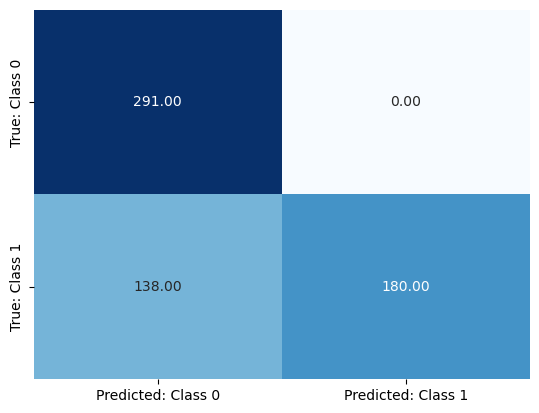

In [123]:
cm = confusion_matrix(results, y)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted: Class 0', 'Predicted: Class 1'], yticklabels=['True: Class 0', 'True: Class 1'], cbar=False)

<Axes: >

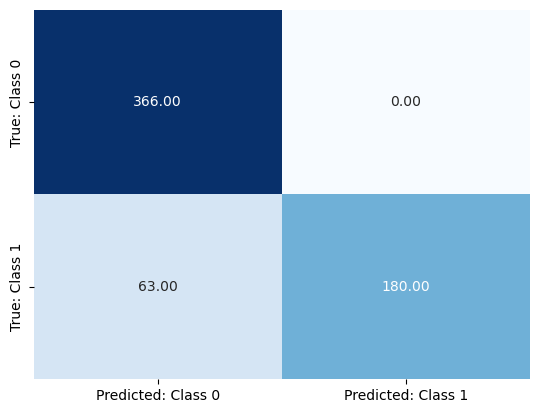

In [125]:
cm = confusion_matrix(results1, y)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted: Class 0', 'Predicted: Class 1'], yticklabels=['True: Class 0', 'True: Class 1'], cbar=False)

In [127]:
print(classification_report(results1, y))

              precision    recall  f1-score   support

       False       0.85      1.00      0.92       366
        True       1.00      0.74      0.85       243

    accuracy                           0.90       609
   macro avg       0.93      0.87      0.89       609
weighted avg       0.91      0.90      0.89       609



In [129]:
all_cols = [col for col in data.columns if "Question_" in col or col == "Screening_result" or col == "ASD_Class"]
data_res = data[all_cols]

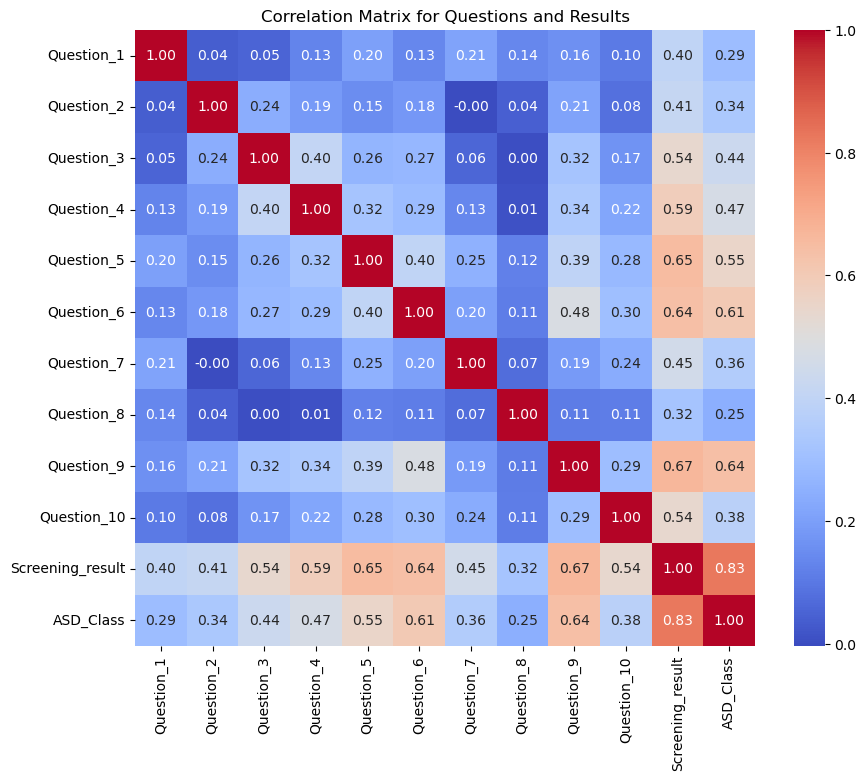

In [131]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_res.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Questions and Results')
plt.show()

In [157]:
results2 = data['Screening_result'] >= 8

(array([ 12.,  26.,  54.,  84., 115.,  75.,  63.,  53.,  51.,  76.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

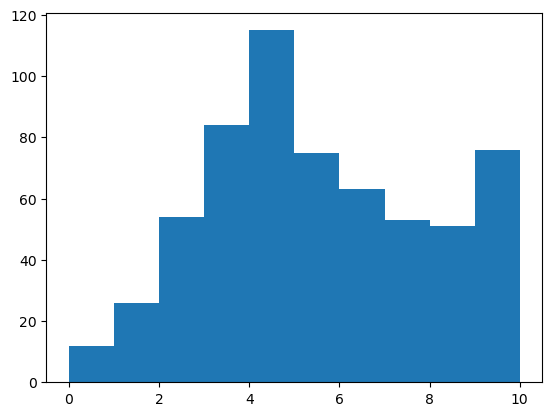

In [159]:
plt.hist(data['Screening_result'])

In [161]:
print(classification_report(results2, y))

              precision    recall  f1-score   support

       False       1.00      0.89      0.94       482
        True       0.71      1.00      0.83       127

    accuracy                           0.91       609
   macro avg       0.85      0.95      0.88       609
weighted avg       0.94      0.91      0.92       609



<Axes: >

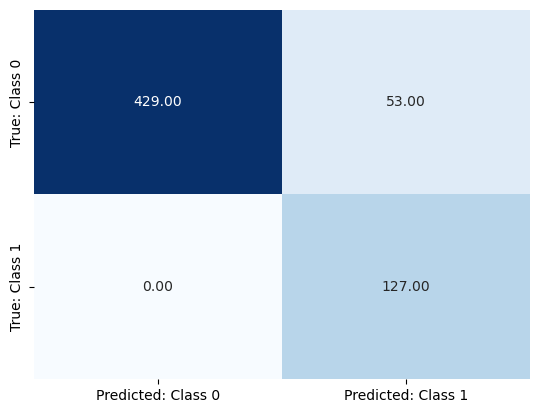

In [163]:
cm = confusion_matrix(results2, y)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted: Class 0', 'Predicted: Class 1'], yticklabels=['True: Class 0', 'True: Class 1'], cbar=False)

# 1. Re-weighting Questions

## Logistic Regression

In [88]:
def analyze_question_importance(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LogisticRegression()
    model.fit(X_scaled, y)

    coefficients = pd.DataFrame({
        'Question': X.columns,
        'Coefficient': model.coef_[0]
    }).sort_values(by='Coefficient', ascending=False)

    print("\nQuestion Importance:")
    print(coefficients)
    return coefficients

In [90]:
coefficients = analyze_question_importance(X_questions, y)


Question Importance:
      Question  Coefficient
4   Question_5     2.000604
3   Question_4     1.864481
8   Question_9     1.844378
6   Question_7     1.807791
7   Question_8     1.701415
5   Question_6     1.695207
0   Question_1     1.681777
1   Question_2     1.681474
2   Question_3     1.670946
9  Question_10     1.545052


<StemContainer object of 3 artists>

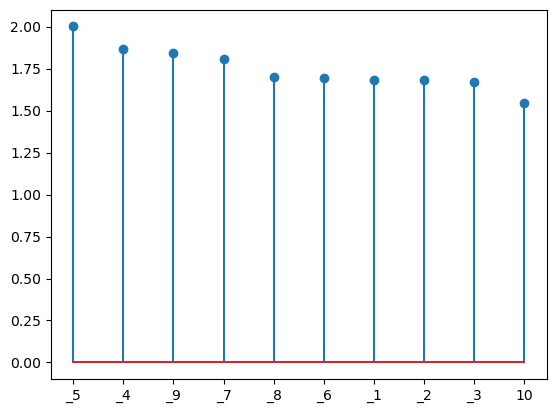

In [92]:
x_lab = [col[-2:] for col in coefficients['Question']]
plt.stem(x_lab, coefficients['Coefficient'])


Question Importance:
      Question  Coefficient
4   Question_5     1.698833
8   Question_9     1.635372
6   Question_7     1.617169
2   Question_3     1.617035
3   Question_4     1.576398
1   Question_2     1.553435
5   Question_6     1.473167
0   Question_1     1.443359
7   Question_8     1.430665
9  Question_10     1.371365

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00        57

    accuracy                           1.00       183
   macro avg       1.00      1.00      1.00       183
weighted avg       1.00      1.00      1.00       183

F1 Score: 1.00


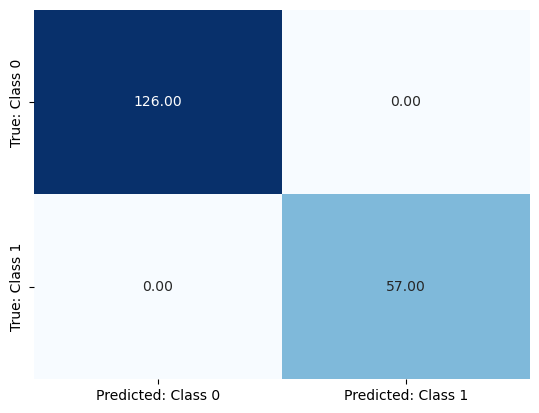

In [102]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_questions, y, test_size=0.3, random_state=10)

# Step 1: Assess importance of each question using Logistic Regression
def analyze_question_importance1(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    coefficients = pd.DataFrame({
        'Question': X_train.columns,
        'Coefficient': model.coef_[0]
    }).sort_values(by='Coefficient', ascending=False)

    print("\nQuestion Importance:")
    print(coefficients)

    # Evaluate performance
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    print("\nLogistic Regression Performance:")
    print(classification_report(y_test, y_pred))
    print(f"F1 Score: {f1:.2f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted: Class 0', 'Predicted: Class 1'], yticklabels=['True: Class 0', 'True: Class 1'], cbar=False)
    
    return coefficients, f1

coefficients, logistic_f1 = analyze_question_importance1(X_train, X_test, y_train, y_test)

## LASSO Selection

In [94]:
def perform_lasso_selection(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)
    selected_features = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': lasso.coef_
    }).query('Coefficient != 0').sort_values(by='Coefficient', ascending=False)

    print("\nFeatures selected by LASSO:")
    print(selected_features)
    return selected_features

In [96]:
selected_features = perform_lasso_selection(X_questions, y)


Features selected by LASSO:
       Feature  Coefficient
8   Question_9     0.124420
5   Question_6     0.107779
4   Question_5     0.073862
6   Question_7     0.066688
1   Question_2     0.064428
7   Question_8     0.060617
3   Question_4     0.060412
2   Question_3     0.059396
0   Question_1     0.045998
9  Question_10     0.026672


<StemContainer object of 3 artists>

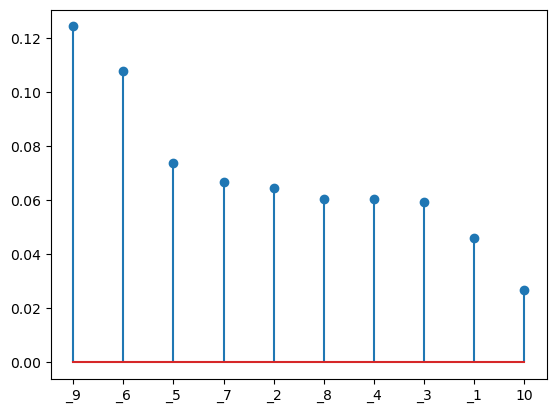

In [98]:
x_lab = [col[-2:] for col in selected_features['Feature']]
plt.stem(x_lab, selected_features['Coefficient'])


Features selected by LASSO:
       Feature  Coefficient
8   Question_9     0.121086
5   Question_6     0.100197
4   Question_5     0.076141
2   Question_3     0.072310
6   Question_7     0.069371
1   Question_2     0.065231
3   Question_4     0.058518
7   Question_8     0.055659
0   Question_1     0.039926
9  Question_10     0.029255

LASSO Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       126
           1       0.93      0.96      0.95        57

    accuracy                           0.97       183
   macro avg       0.96      0.97      0.96       183
weighted avg       0.97      0.97      0.97       183

F1 Score: 0.95


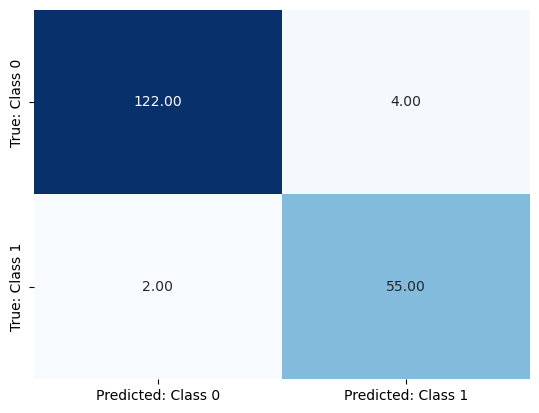

In [104]:
def perform_lasso_selection_test(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lasso = LassoCV(cv=5, random_state=5).fit(X_train_scaled, y_train)
    selected_features = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': lasso.coef_
    }).query('Coefficient != 0').sort_values(by='Coefficient', ascending=False)

    print("\nFeatures selected by LASSO:")
    print(selected_features)

    # Evaluate performance
    y_pred = (lasso.predict(X_test_scaled) > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred)
    print("\nLASSO Performance:")
    print(classification_report(y_test, y_pred))
    print(f"F1 Score: {f1:.2f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted: Class 0', 'Predicted: Class 1'], yticklabels=['True: Class 0', 'True: Class 1'], cbar=False)

    return selected_features, f1

In [ ]:
selected_features, lasso_f1 = perform_lasso_selection_test(X_train, X_test, y_train, y_test)

# 2. PCA on Questions

In [180]:
def perform_pca(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA()
    principal_components = pca.fit_transform(X_scaled)

    explained_variance = pd.DataFrame({
        'Principal Component': [f'PC{i+1}' for i in range(pca.n_components_)],
        'Explained Variance Ratio': pca.explained_variance_ratio_
    })

    print("\nPrincipal Components and Explained Variance:")
    print(explained_variance)

    pc_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    return pc_df, explained_variance, pca

In [182]:
principal_components_df, explained_variance, pca = perform_pca(X_questions)


Principal Components and Explained Variance:
  Principal Component  Explained Variance Ratio
0                 PC1                  0.290439
1                 PC2                  0.125951
2                 PC3                  0.097699
3                 PC4                  0.090498
4                 PC5                  0.079767
5                 PC6                  0.075298
6                 PC7                  0.069919
7                 PC8                  0.061472
8                 PC9                  0.057741
9                PC10                  0.051217


In [285]:
def pca_analysis(pc_df, explained_variance, pca, y):
    # Stem plot
    plt.figure(figsize=(10, 6))
    col = ['r', 'b', 'g']
    for i in range(3):
        plt.plot(range(len(pca.components_[i])), pca.components_[i], label=f'PC{i+1}', color = col[i])
    plt.legend()
    plt.title('PCA Component Weights')
    plt.xlabel('Original Features')
    plt.ylabel('Weight')
    plt.show()

    # Scree plot for explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(explained_variance['Principal Component'], explained_variance['Explained Variance Ratio'])
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

    # Select top 3 PCs for logistic regression
    k_val = [1, 2, 3]
    f1_all = []
    cm_all = []
    for k in k_val:
        print('k =', k)
        X_pca_top3 = pc_df.iloc[:, :k]
        f1_scores = []
        cm = []
    
        for i in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X_pca_top3, y, test_size=0.3, random_state=i)
    
            model = LogisticRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            f1_scores.append(f1_score(y_test, y_pred))
            cm.append(confusion_matrix(y_test, y_pred))
            # print(classification_report(y_test, y_pred))
    
        cm = np.mean(np.array(cm), axis = 0)
        cm_all.append(cm)
        print("\nAverage F1 Score using top 3 PCs:", np.mean(f1_scores))
        f1_all.append(np.mean(f1_scores))
    
    return cm_all, f1_all

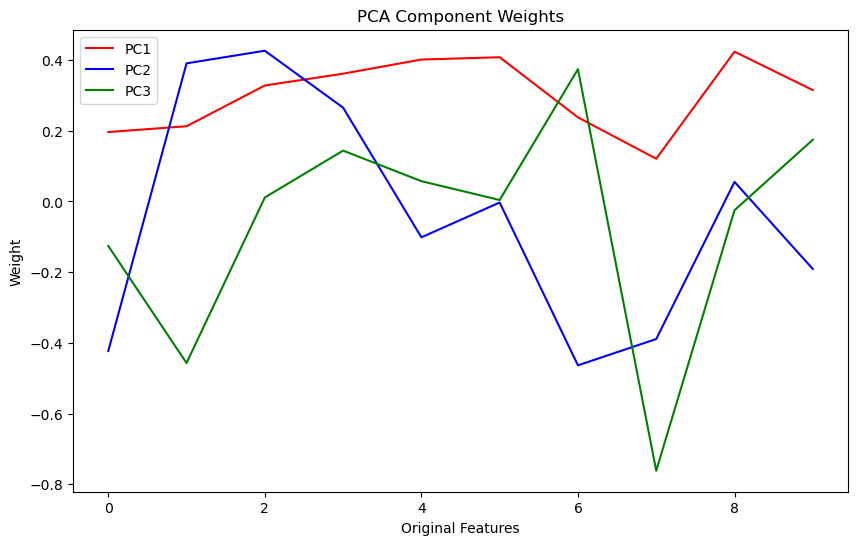

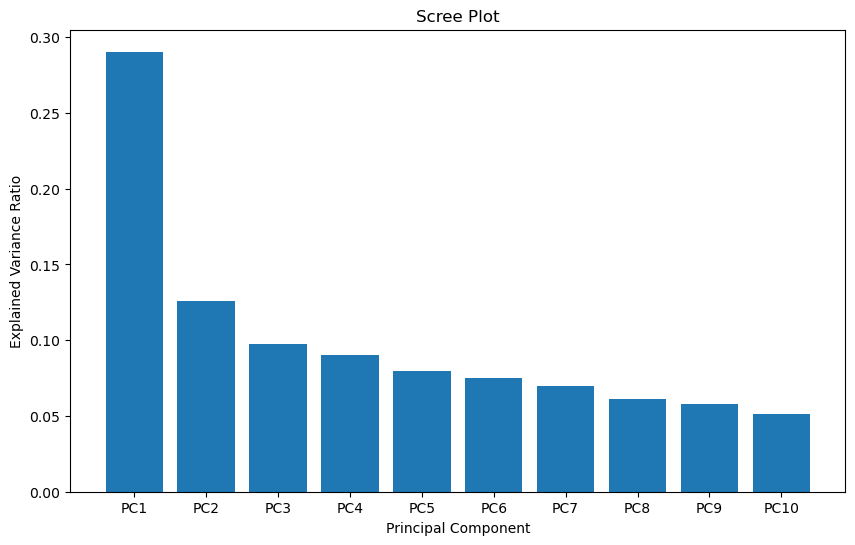

k = 1

Average F1 Score using top 3 PCs: 0.9280555014043973
k = 2

Average F1 Score using top 3 PCs: 0.9602330957628402
k = 3

Average F1 Score using top 3 PCs: 0.9884395908101282


In [287]:
cm, f1 = pca_analysis(principal_components_df, explained_variance, pca, y)

## Testing Logistic Regressor on PCA

[0.9280555014043973, 0.9602330957628402, 0.9884395908101282]


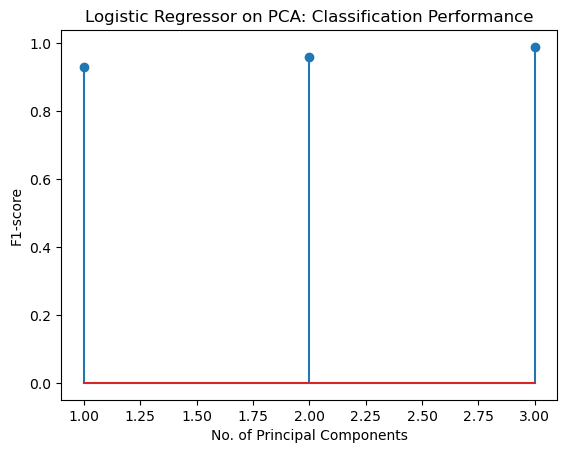

In [291]:
pcs = [1, 2, 3]
print(f1)

plt.figure()
plt.stem(pcs, f1)
plt.title('Logistic Regressor on PCA: Classification Performance')
plt.xlabel('No. of Principal Components')
plt.ylabel('F1-score')
plt.show()

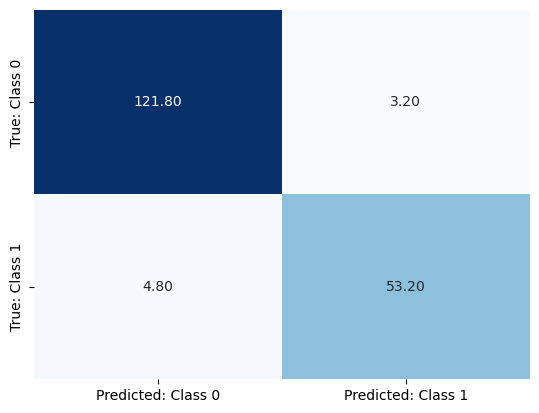

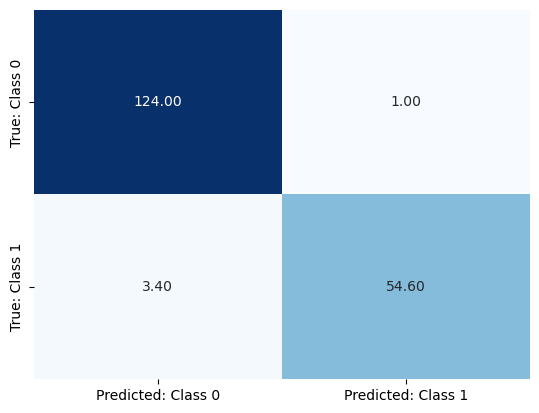

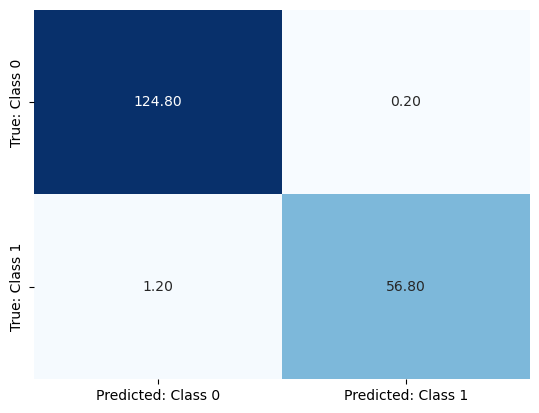

In [295]:
for k in pcs:
    plt.figure
    sns.heatmap(cm[k - 1], annot=True, fmt='.2f', cmap='Blues', xticklabels=['Predicted: Class 0', 'Predicted: Class 1'], yticklabels=['True: Class 0', 'True: Class 1'], cbar=False)
    plt.show()

# 3. Question Importance within Demographics

In [316]:
print(data.columns)

Index(['Question_1', 'Question_2', 'Question_3', 'Question_4', 'Question_5',
       'Question_6', 'Question_7', 'Question_8', 'Question_9', 'Question_10',
       'age', 'gender', 'ethnicity', 'Born_with_jaundice',
       'Family_member_with_ASD', 'Country_of_residence', 'Used_screening_app',
       'Screening_result', 'Relation_to_test', 'ASD_Class'],
      dtype='object')


## Ethnicity

### Latino

In [300]:
# Filter rows where ethnicity is Latino
data_latino = data[data['ethnicity'] == 'Latino']

# Separate features and labels for the filtered data
question_cols = [col for col in data_latino.columns if "Question_" in col]

X_questions = data_latino[question_cols]
y = data_latino['ASD_Class']

In [302]:
selected_features = perform_lasso_selection(X_questions, y)


Features selected by LASSO:
       Feature  Coefficient
0   Question_1     0.201435
6   Question_7     0.177775
8   Question_9     0.174127
4   Question_5     0.141074
3   Question_4     0.134782
9  Question_10     0.075770
2   Question_3     0.060768
1   Question_2     0.049219
5   Question_6     0.037893
7   Question_8    -0.000669


<StemContainer object of 3 artists>

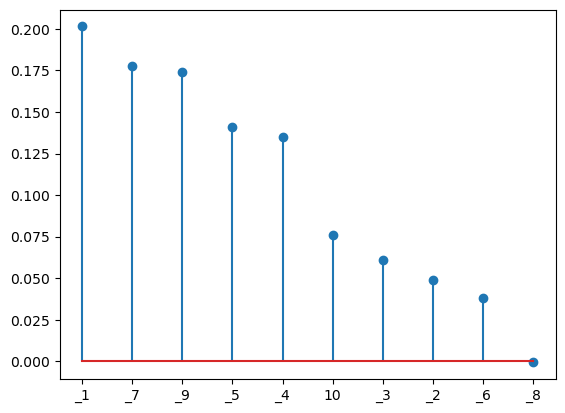

In [304]:
x_lab = [col[-2:] for col in selected_features['Feature']]
plt.stem(x_lab, selected_features['Coefficient'])

### White-Eurpoean

In [369]:
# Filter rows where ethnicity is Latino
data_latino = data[data['ethnicity'] == 'White-European']

# Separate features and labels for the filtered data
question_cols = [col for col in data_latino.columns if "Question_" in col]

X_questions = data_latino[question_cols]
y = data_latino['ASD_Class']

In [371]:
selected_features = perform_lasso_selection(X_questions, y)


Features selected by LASSO:
       Feature  Coefficient
8   Question_9     0.152965
4   Question_5     0.115536
5   Question_6     0.110876
1   Question_2     0.052412
7   Question_8     0.051029
6   Question_7     0.049914
9  Question_10     0.048044
0   Question_1     0.042316
3   Question_4     0.042113
2   Question_3     0.031278


<StemContainer object of 3 artists>

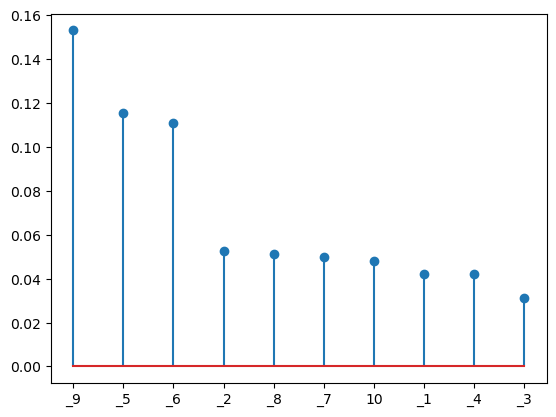

In [373]:
x_lab = [col[-2:] for col in selected_features['Feature']]
plt.stem(x_lab, selected_features['Coefficient'])

### Asian

In [307]:
# Filter rows where ethnicity is Latino
data_latino = data[data['ethnicity'] == 'Asian']

# Separate features and labels for the filtered data
question_cols = [col for col in data_latino.columns if "Question_" in col]

X_questions = data_latino[question_cols]
y = data_latino['ASD_Class']


Features selected by LASSO:
       Feature  Coefficient
5   Question_6     0.077318
2   Question_3     0.076843
6   Question_7     0.071249
3   Question_4     0.065775
1   Question_2     0.059213
7   Question_8     0.058861
8   Question_9     0.050624
4   Question_5     0.048872
9  Question_10     0.023819
0   Question_1     0.002061


<StemContainer object of 3 artists>

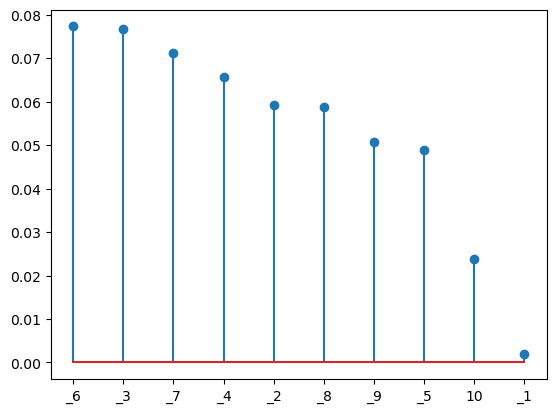

In [309]:
selected_features = perform_lasso_selection(X_questions, y)
x_lab = [col[-2:] for col in selected_features['Feature']]
plt.stem(x_lab, selected_features['Coefficient'])

## Relation has Autism

In [312]:
# Filter rows where ethnicity is Latino
data_latino = data[data['Family_member_with_ASD'] == 1]

# Separate features and labels for the filtered data
question_cols = [col for col in data_latino.columns if "Question_" in col]

X_questions = data_latino[question_cols]
y = data_latino['ASD_Class']


Features selected by LASSO:
      Feature  Coefficient
8  Question_9     0.155185
5  Question_6     0.108093
2  Question_3     0.095410
7  Question_8     0.079522
0  Question_1     0.079462
6  Question_7     0.072922
4  Question_5     0.053097
1  Question_2     0.045144
3  Question_4     0.042506


<StemContainer object of 3 artists>

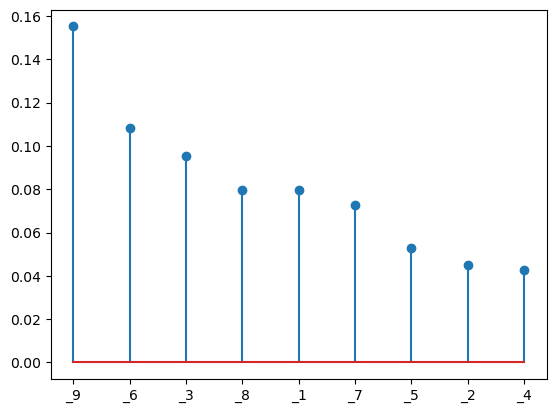

In [314]:
selected_features = perform_lasso_selection(X_questions, y)
x_lab = [col[-2:] for col in selected_features['Feature']]

plt.figure()
plt.stem(x_lab, selected_features['Coefficient'])
plt.show()

## Gender

### Male

In [339]:
# Filter rows where ethnicity is Latino
data_latino = data[data['gender'] == 'm']

# Separate features and labels for the filtered data
question_cols = [col for col in data_latino.columns if "Question_" in col]

X_questions = data_latino[question_cols]
y = data_latino['ASD_Class']


Features selected by LASSO:
       Feature  Coefficient
8   Question_9     0.122804
5   Question_6     0.105281
6   Question_7     0.077180
2   Question_3     0.064139
4   Question_5     0.062878
1   Question_2     0.058858
7   Question_8     0.056664
3   Question_4     0.050169
0   Question_1     0.046519
9  Question_10     0.022565


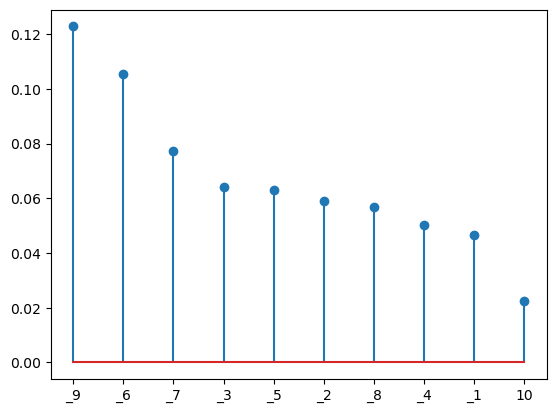

In [341]:
selected_features_m = perform_lasso_selection(X_questions, y)
x_lab_m = [col[-2:] for col in selected_features_m['Feature']]

plt.figure()
plt.stem(x_lab_m, selected_features_m['Coefficient'])
plt.show()

### Female

In [344]:
# Filter rows where ethnicity is Latino
data_latino = data[data['gender'] == 'f']

# Separate features and labels for the filtered data
question_cols = [col for col in data_latino.columns if "Question_" in col]

X_questions = data_latino[question_cols]
y = data_latino['ASD_Class']


Features selected by LASSO:
       Feature  Coefficient
8   Question_9     0.126372
5   Question_6     0.105872
4   Question_5     0.083562
3   Question_4     0.071187
7   Question_8     0.067969
1   Question_2     0.067819
6   Question_7     0.059920
2   Question_3     0.055354
0   Question_1     0.040620
9  Question_10     0.027647


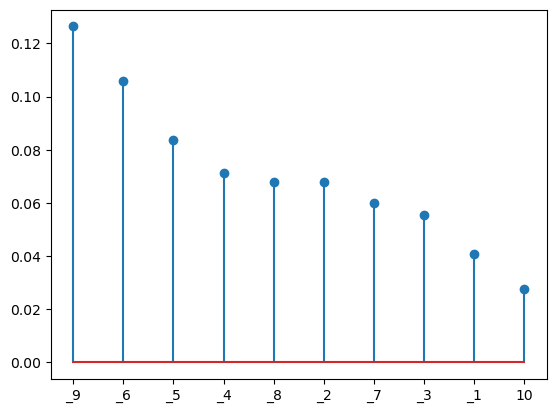

In [346]:
selected_features_f = perform_lasso_selection(X_questions, y)
x_lab_f = [col[-2:] for col in selected_features_f['Feature']]

plt.figure()
plt.stem(x_lab_f, selected_features_f['Coefficient'])
plt.show()